In [3]:
import pandas as pd
import math
import random
import numpy as np
import copy
import xlsxwriter
import matplotlib.pyplot as plt
import time

class Sol():
    def __init__(self):
        self.nodes_seq=None
        self.obj=None
        self.routes=None
        self.distance = None
        self.num_vehicle = None
        self.over_due = None
class Node():
    def __init__(self):
        self.id=0
        self.name=''
        self.seq_no=0
        self.x_coord=0
        self.y_coord=0
        self.demand=0
        self.left_time_window = 0
        self.right_time_window = 0
        self.service_time = 0
        self.distance_to_depot = 0
class Model():
    '''
    Model()类，存储算法参数
    params:
    best_sol：全局最优解，值类型为Sol()
    node_list：物理节点集合，值类型为Node()
    sol_list：可行解集合，值类型为Sol()
    node_seq_no_list：物理节点映射id集合
    depot：车辆基地，值类型为Node()
    number_of_nodes：需求节点数量
    opt_type:优化目标类型，0：最小车辆数，1：最小行驶距离
    vehicle_cap:车辆容量
    distance:网络弧距离
    popsize:蚁群规模
    alpha:信息启发式因子
    beta:期望启发式因子
    Q:信息素总量
    rho:信息素挥发系数
    tau:网络弧信息素
    '''
    def __init__(self):
        self.best_sol=None
        self.node_list=[]
        self.sol_list=[]
        self.node_seq_no_list=[]
        self.depot=None
        self.number_of_nodes=0
        self.opt_type=0
        self.vehicle_cap=0
        self.distance = None
        self.popsize=100
        self.alpha=2
        self.beta=3
        self.Q=100
        self.rho=0.5
        self.tau=None
        self.speed = 20
def readXlsxFile(filepath,model):
    df = pd.read_excel(filepath)
    node_seq_no = -1
    for i in range(df.shape[0]):
        # 每次循环生成一个node类对象
        node=Node()
        # 从-1开始赋予id，仓库id为-1
        node.id=node_seq_no
        node.seq_no=node_seq_no
        node.x_coord= df['x_coord'][i]
        node.y_coord= df['y_coord'][i]
        node.demand=df['demand'][i]
        node.left_time_window = df['left_time_window'][i]
        node.right_time_window = df['right_time_window'][i]
        node.service_time = df['service_time'][i]
        if df['demand'][i] == 0:
            model.depot=node
        else:
            model.node_list.append(node)
            # 储存映射id，与excel表中的id不一致
            model.node_seq_no_list.append(node_seq_no)
        try:
            node.name=df['name'][i]
        except:
            pass
        # 如果有id号，尝试添加id
        try:
            node.id=df['id'][i]
        except:
            pass
        node_seq_no=node_seq_no+1
    model.number_of_nodes=len(model.node_list)

In [4]:
def initParam(model,distance_type = 0,distance_matrix = None,distance_to_depot = None):
    # 初始化距离邻接矩阵与信息素矩阵
    model.distance = np.zeros((model.number_of_nodes,model.number_of_nodes))
    model.tau = np.ones((model.number_of_nodes,model.number_of_nodes))*10
    if distance_type == 0:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = np.sqrt((model.node_list[i].x_coord-model.depot.x_coord)**2+\
                            (model.node_list[i].y_coord-model.depot.y_coord)**2) 
            for j in range(i+1,model.number_of_nodes):
                d=np.sqrt((model.node_list[i].x_coord-model.node_list[j].x_coord)**2+\
                            (model.node_list[i].y_coord-model.node_list[j].y_coord)**2)
                model.distance[i,j]=d
                model.distance[j,i]=d
    elif distance_type == 1:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = np.abs(model.node_list[i].x_coord-model.depot.x_coord)+\
                            np.abs(model.node_list[i].y_coord-model.depot.y_coord)
            for j in range(i+1,model.number_of_nodes):
                d=np.abs(model.node_list[i].x_coord-model.node_list[j].x_coord)+\
                            np.abs(model.node_list[i].y_coord-model.node_list[j].y_coord)
                model.distance[i,j]=d
                model.distance[j,i]=d
    elif distance_type == 3:
        for i in range(model.number_of_nodes):
            model.node_list[i].distance_to_depot = distance_to_depot[i]
        model.distance = distance_matrix

In [5]:
def splitRoutes(nodes_seq,model):
    num_vehicle = 0
    vehicle_routes = []
    route = []
    remained_cap = model.vehicle_cap
    # 计算仓库到该路线第一个配送点时间
    time_counter = 0
    over_due = 0
    
    for i in range(len(nodes_seq)):
        ### 第一层条件语句判断是否满足容量约束
        if remained_cap - model.node_list[nodes_seq[i]].demand >= 0:
            ## 第二层第一个条件语句判断路径是否为空，不为空则路径中已存在配送点
            if len(route)== 0:
                time_counter = model.node_list[nodes_seq[i]].distance_to_depot/model.speed
            else:
                time_counter+= model.distance[range(model.number_of_nodes).index(route[-1]),\
                                             range(model.number_of_nodes).index(nodes_seq[i])]/model.speed
            ## 第二层第二个条件语句计算到达时间与时间窗    
            if time_counter < model.node_list[nodes_seq[i]].left_time_window:
                #小于左时间窗，计时器从左时间窗起加服务时间
                time_counter = model.node_list[nodes_seq[i]].left_time_window + model.node_list[nodes_seq[i]].service_time
                route.append(nodes_seq[i])
                remained_cap = remained_cap - model.node_list[nodes_seq[i]].demand
            elif (time_counter >= model.node_list[nodes_seq[i]].left_time_window)&\
                                            (time_counter<=model.node_list[nodes_seq[i]].right_time_window):
                #大于左时间窗小于右时间窗，计时器自增服务时间
                time_counter += model.node_list[nodes_seq[i]].service_time
                route.append(nodes_seq[i])
                remained_cap = remained_cap - model.node_list[nodes_seq[i]].demand
            else:
                #超出时间窗
                if len(route)==0:
                    route.append(nodes_seq[i])
                    vehicle_routes.append(route)
                    over_due+=1
                    route = []
                else:
                    vehicle_routes.append(route)
                    route = [nodes_seq[i]]
                    time_counter = model.node_list[nodes_seq[i]].distance_to_depot
                    remained_cap = model.vehicle_cap - model.node_list[nodes_seq[i]].demand
                
        else:
            vehicle_routes.append(route)
            route = [nodes_seq[i]]
            time_counter = model.node_list[nodes_seq[i]].distance_to_depot/model.speed
            remained_cap = model.vehicle_cap - model.node_list[nodes_seq[i]].demand
            
    if len(route)>0:
        vehicle_routes.append(route)
    num_vehicle = len(vehicle_routes)
    return num_vehicle,vehicle_routes,over_due

In [6]:
def calDistance(route,model):
    distance=0
    for i in range(len(route)-1):
        distance += model.distance[route[i],route[i+1]]
    distance+=model.node_list[route[0]].distance_to_depot
    distance+=model.node_list[route[-1]].distance_to_depot
    return distance

def calObj(nodes_seq,model,a=10,b=1):
    num_vehicle, vehicle_routes,over_due = splitRoutes(nodes_seq, model)
    if model.opt_type==0:
        return num_vehicle,vehicle_routes
    elif model.opt_type==1:
        distance=0
        for route in vehicle_routes:
            distance+=calDistance(route,model)
        return distance,vehicle_routes
    else:
        distance=0
        for route in vehicle_routes:
            distance+=calDistance(route,model)
        return a*num_vehicle+b*distance,vehicle_routes

In [7]:
def movePosition(model):
    sol_list=[]
    local_sol=Sol()
    local_sol.obj=float('inf')
    for k in range(model.popsize):
        #Random ant position
        nodes_seq=[int(random.randint(0,model.number_of_nodes-1))]
        all_nodes_seq=copy.deepcopy(model.node_seq_no_list)
        all_nodes_seq.remove(nodes_seq[-1])
        #Determine the next moving position according to pheromone
        while len(all_nodes_seq)>0:
            # 调用searchNextNode方法直到没有新的未走过的节点，生成一只蚂蚁的路径列表
            next_node_no=searchNextNode(model,nodes_seq[-1],all_nodes_seq)
            nodes_seq.append(next_node_no)
            all_nodes_seq.remove(next_node_no)
        sol=Sol()
        sol.nodes_seq=nodes_seq
        sol.obj,sol.routes=calObj(nodes_seq,model)
        sol.num_vehicle = len(sol.routes)
        sol_list.append(sol)
        if sol.obj<local_sol.obj:
            local_sol=copy.deepcopy(sol)
    model.sol_list=copy.deepcopy(sol_list)
    if local_sol.obj<model.best_sol.obj:
        model.best_sol=copy.deepcopy(local_sol)

def searchNextNode(model,current_node_no,SE_List):
    '''
    searchNextNode(model,current_node_no,SE_List)
    params:
    model:模型参数
    current_node_no:该蚂蚁出发点
    SE_List:蚂蚁未行走地点
    '''
    prob=np.zeros(len(SE_List))
    # enumerate返回可迭代对象中的索引与对象
    # 根据距离计算每个节点的信息素浓度
    for i,node_no in enumerate(SE_List):
        eta=1/model.distance[current_node_no,node_no]
        tau=model.tau[current_node_no,node_no]
        # 计算未行走地点的信息素浓度
        prob[i]=((eta**model.alpha)*(tau**model.beta))
    # use Roulette to determine the next node
    # 根据轮盘赌算法计算接下来的行走节点
    cumsumprob=(prob/sum(prob)).cumsum()
    cumsumprob -= np.random.rand()
    next_node_no= SE_List[list(cumsumprob > 0).index(True)]
    return next_node_no

In [8]:
def upateTau(model):
    rho=model.rho
    model.tau=(1-rho)*model.tau
    #update tau according to sol.nodes_seq(solution of TSP)
    for sol in model.sol_list:
        nodes_seq=sol.nodes_seq
        for i in range(len(nodes_seq)-1):
            from_node_no=nodes_seq[i]
            to_node_no=nodes_seq[i+1]
            model.tau[from_node_no,to_node_no]+=model.Q/sol.obj

def plotObj(obj_list):
    plt.rcParams['font.sans-serif'] = ['SimHei']  #show chinese
    plt.rcParams['axes.unicode_minus'] = False   # Show minus sign
    plt.plot(np.arange(1,len(obj_list)+1),obj_list)
    plt.xlabel('Iterations')
    plt.ylabel('Obj Value')
    plt.grid()
    plt.xlim(1,len(obj_list)+1)
    plt.show()
def outPut(model):
    work=xlsxwriter.Workbook('result.xlsx')
    worksheet=work.add_worksheet()
    worksheet.write(0,0,'opt_type')
    worksheet.write(1,0,'obj')
    if model.opt_type==0:
        worksheet.write(0,1,'number of vehicles')
    else:
        worksheet.write(0, 1, 'drive distance of vehicles')
    worksheet.write(1,1,model.best_sol.obj)
    for row,route in enumerate(model.best_sol.routes):
        worksheet.write(row+2,0,'v'+str(row+1))
        r=[str(i)for i in route]
        worksheet.write(row+2,1, '-'.join(r))
    work.close()

In [9]:
def run(filepath,Q,alpha,beta,rho,epochs,v_cap,opt_type,popsize):
    """
    :param filepath:Xlsx file path
    :param Q:Total pheromone(外激素; 信息素)
    :param alpha:Information heuristic factor
    :param beta:Expected heuristic factor
    :param rho:Information volatilization factor
    :param epochs:Iterations
    :param v_cap:Vehicle capacity
    :param opt_type:Optimization type:0:Minimize the number of vehicles,1:Minimize travel distance
    :param popsize:Population size
    :return:
    """
    model=Model()
    model.vehicle_cap=v_cap
    model.opt_type=opt_type
    model.alpha=alpha
    model.beta=beta
    model.Q=Q 
    model.rho=rho # rho:信息素挥发系数
    model.popsize=popsize # popsize:蚁群规模
    sol=Sol()
    sol.obj=float('inf')
    model.best_sol=sol
    history_best_obj = []
    readXlsxFile(filepath,model)
    initParam(model)
    for ep in range(epochs):
        movePosition(model)
        upateTau(model)
        history_best_obj.append(model.best_sol.obj)
        print("%s/%s， best obj: %s,num_vehicles: %s" % (ep,epochs, model.best_sol.obj,model.best_sol.num_vehicle))
    plotObj(history_best_obj)
    outPut(model)

0/200， best obj: 3715.1815444187914,num_vehicles: 44
1/200， best obj: 3680.2258260854564,num_vehicles: 41
2/200， best obj: 3641.7866913837106,num_vehicles: 42
3/200， best obj: 3641.7866913837106,num_vehicles: 42
4/200， best obj: 3532.451222002695,num_vehicles: 42
5/200， best obj: 3532.451222002695,num_vehicles: 42
6/200， best obj: 3499.878385033616,num_vehicles: 41
7/200， best obj: 3499.878385033616,num_vehicles: 41
8/200， best obj: 3499.878385033616,num_vehicles: 41
9/200， best obj: 3499.878385033616,num_vehicles: 41
10/200， best obj: 3499.878385033616,num_vehicles: 41
11/200， best obj: 3499.878385033616,num_vehicles: 41
12/200， best obj: 3499.878385033616,num_vehicles: 41
13/200， best obj: 3499.878385033616,num_vehicles: 41
14/200， best obj: 3499.878385033616,num_vehicles: 41
15/200， best obj: 3499.878385033616,num_vehicles: 41
16/200， best obj: 3499.878385033616,num_vehicles: 41
17/200， best obj: 3499.878385033616,num_vehicles: 41
18/200， best obj: 3498.8409467222996,num_vehicles: 4

154/200， best obj: 2516.422738398902,num_vehicles: 39
155/200， best obj: 2516.422738398902,num_vehicles: 39
156/200， best obj: 2516.422738398902,num_vehicles: 39
157/200， best obj: 2516.422738398902,num_vehicles: 39
158/200， best obj: 2516.422738398902,num_vehicles: 39
159/200， best obj: 2516.422738398902,num_vehicles: 39
160/200， best obj: 2516.422738398902,num_vehicles: 39
161/200， best obj: 2516.422738398902,num_vehicles: 39
162/200， best obj: 2516.422738398902,num_vehicles: 39
163/200， best obj: 2516.422738398902,num_vehicles: 39
164/200， best obj: 2516.422738398902,num_vehicles: 39
165/200， best obj: 2516.422738398902,num_vehicles: 39
166/200， best obj: 2516.422738398902,num_vehicles: 39
167/200， best obj: 2516.422738398902,num_vehicles: 39
168/200， best obj: 2516.422738398902,num_vehicles: 39
169/200， best obj: 2516.422738398902,num_vehicles: 39
170/200， best obj: 2516.422738398902,num_vehicles: 39
171/200， best obj: 2516.422738398902,num_vehicles: 39
172/200， best obj: 2516.4227

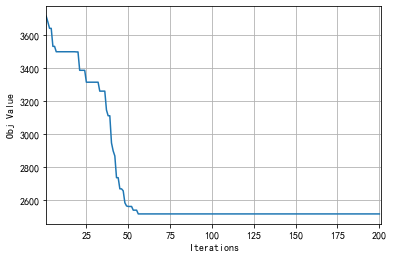

whole time: 114.33670115470886


In [10]:
start_time = time.time()
file='C:/Users/lisuc/Desktop/Algorithms_for_solving_VRP-master/data/c101.xlsx'
run(file,Q=10,alpha=1,beta=5,rho=0.1,epochs=200,v_cap=100,opt_type=1,popsize=30)
end_time = time.time()
print("whole time:",end_time - start_time)